In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from matplotlib import pyplot as plt

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2485 files belonging to 2 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [ ]:
len(dataset)

78

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1]


In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())
    print(image_batch[0].shape)

[[[128. 118. 129.]
  [119. 109. 120.]
  [ 90.  80.  91.]
  ...
  [145. 134. 140.]
  [136. 125. 131.]
  [145. 134. 140.]]

 [[115. 105. 116.]
  [122. 112. 123.]
  [115. 105. 116.]
  ...
  [113. 102. 108.]
  [119. 108. 114.]
  [133. 122. 128.]]

 [[100.  90. 101.]
  [130. 120. 131.]
  [116. 106. 117.]
  ...
  [113. 102. 108.]
  [129. 118. 124.]
  [147. 136. 142.]]

 ...

 [[215. 210. 216.]
  [199. 194. 200.]
  [206. 201. 207.]
  ...
  [142. 132. 131.]
  [147. 137. 136.]
  [139. 129. 128.]]

 [[240. 235. 241.]
  [204. 199. 205.]
  [237. 232. 238.]
  ...
  [152. 142. 141.]
  [165. 155. 154.]
  [159. 149. 148.]]

 [[210. 205. 211.]
  [225. 220. 226.]
  [204. 199. 205.]
  ...
  [147. 137. 136.]
  [163. 153. 152.]
  [158. 148. 147.]]]
(256, 256, 3)


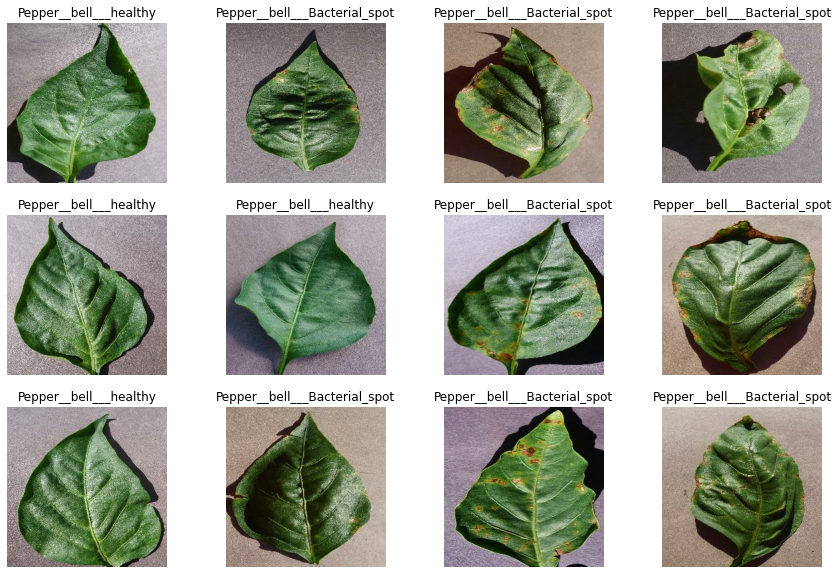

In [ ]:
plt.figure(figsize=(15,10))
for image_batch, label_batch in dataset.take(1):
    
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [ ]:
train_ds, test_ds, val_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

62

In [ ]:
len(test_ds)

9

In [ ]:
len(val_ds)

7

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
62/62 [==============================] - 724s 176ms/step - loss: 0.5719 - accuracy: 0.7212 - val_loss: 0.3125 - val_accuracy: 0.8705
Epoch 2/50
62/62 [==============================] - 6s 93ms/step - loss: 0.2499 - accuracy: 0.9103 - val_loss: 0.4104 - val_accuracy: 0.8616
Epoch 3/50
62/62 [==============================] - 6s 93ms/step - loss: 0.1548 - accuracy: 0.9478 - val_loss: 0.2006 - val_accuracy: 0.9464
Epoch 4/50
62/62 [==============================] - 6s 94ms/step - loss: 0.0928 - accuracy: 0.9706 - val_loss: 0.1388 - val_accuracy: 0.9777
Epoch 5/50
62/62 [==============================] - 6s 93ms/step - loss: 0.0535 - accuracy: 0.9848 - val_loss: 0.2621 - val_accuracy: 0.9062
Epoch 6/50
62/62 [==============================] - 6s 93ms/step - loss: 0.0531 - accuracy: 0.9818 - val_loss: 0.0528 - val_accuracy: 0.9911
Epoch 7/50
62/62 [==============================] - 6s 93ms/step - loss: 0.0253 - accuracy: 0.9929 - val_loss: 0.0999 - val_accuracy: 0.9598
Epoch 8/50

In [ ]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 4s 34ms/step - loss: 0.0102 - accuracy: 0.9931


In [ ]:
scores

[0.010245921090245247, 0.9930555820465088]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 62}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history.history['accuracy']

[0.7212367057800293,
 0.91028892993927,
 0.9477952122688293,
 0.9706031680107117,
 0.9847947359085083,
 0.9817536473274231,
 0.9929041862487793,
 0.9842878580093384,
 0.9853015542030334,
 0.9868220686912537,
 0.9954383969306946,
 0.9964520931243896,
 0.9929041862487793,
 0.9959452748298645,
 0.991890549659729,
 0.9939178824424744,
 0.9984794855117798,
 0.990369975566864,
 0.9923973679542542,
 0.9954383969306946,
 0.9934110641479492,
 0.991890549659729,
 0.990369975566864,
 0.9923973679542542,
 0.9969589710235596,
 0.9979726076126099,
 0.9969589710235596,
 0.990369975566864,
 0.9934110641479492,
 0.9989863038063049,
 0.9974657893180847,
 0.9979726076126099,
 0.9984794855117798,
 0.9989863038063049,
 0.9908768534660339,
 0.982260525226593,
 0.9923973679542542,
 0.9969589710235596,
 0.9984794855117798,
 0.9969589710235596,
 0.9964520931243896,
 0.9979726076126099,
 0.9964520931243896,
 0.9994931817054749,
 0.9984794855117798,
 0.9989863038063049,
 0.9959452748298645,
 0.9959452748298645,


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

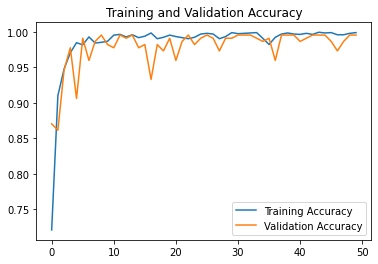

In [ ]:
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

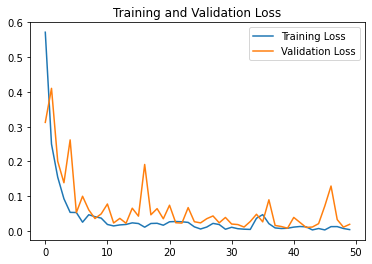

In [ ]:
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")

first image to predict
actual label: Pepper__bell___Bacterial_spot
1/1 [==============================] - 0s 29ms/step
predicted label: Pepper__bell___Bacterial_spot


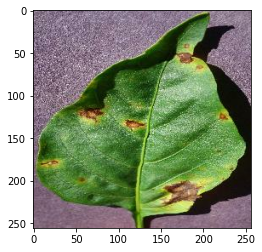

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 15ms/step


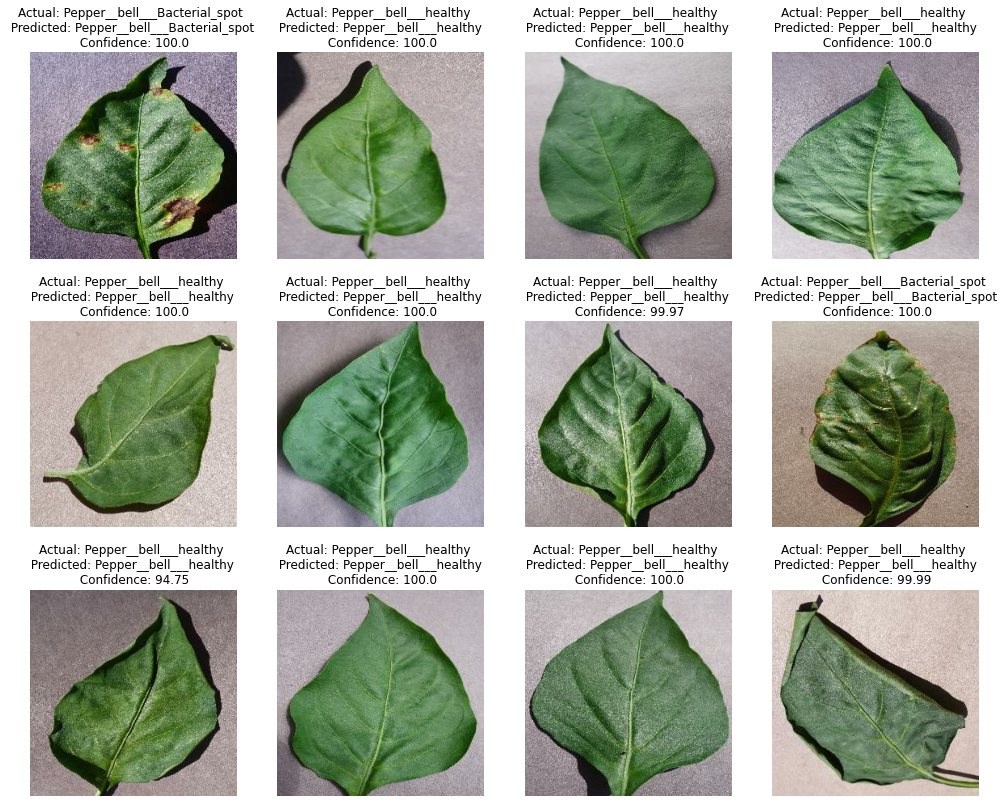

In [ ]:
plt.figure(figsize=(17,14))
for image_batch, label_batch in test_ds.take(1):
    
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, image_batch[i])
        actual_class = class_names[label_batch[i]]

        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}")
        plt.axis('off')

In [ ]:
model_version = 1
model.save(f"/content/drive/MyDrive/Models{model_version}")